## **Basic Features - Phase 1 (Trades + Aggregates)**

**Purpose:** Engineer microstructure features from AAPL trade ticks and minute aggregates

**What it does:**

- Computes trade-derived features (Lee-Ready classification, VPIN, trade size metrics, intensity)
- Computes aggregate-derived features (spread, mid-price, volatility, VWAP deviation)
- Creates unified feature DataFrame aligned to 1-minute bars
- Exports features for dimensionality reduction (next notebook)

**Data Sources (Phase 1):**

- **Trades**: Individual trade ticks ✓ Available
- **Aggregates**: Minute OHLCV bars ✓ Available
- **Quotes**: NBBO tick quotes ⚠️ Will record later
- **LOB**: L2 order book ✗ Not available

**Features Computed:** ~30-35 features (trade + aggregate derived)

**Note:** Lee-Ready uses aggregate mid-price approximation (will enhance with tick quotes in Phase 2)


In [1]:
# ============================================================================
# 10_basic_features.ipynb
# Purpose: Compute Phase 1 microstructure features from AAPL trades + aggregates
# ============================================================================

# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import json

# Visualization settings
plt.style.use('seaborn-v0_8-paper')  
plt.rcParams.update({
    'font.family': 'serif',
    'font.weight': 'bold',        
    'axes.labelweight': 'bold',    
    'axes.titleweight': 'bold',   
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
%matplotlib inline

from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, FIGURES_DIR
from src.utils.data_quality import check_data_quality, print_quality_report

In [2]:
# %% Configuration
TICKER = "AAPL"
DATE = "2024-12-09"

print(f"Ticker: {TICKER}")
print(f"Date: {DATE}")
print(f"\nData Status:")
print(f"  Trades: ✓ Available")
print(f"  Aggregates: ✓ Available")
print(f"  NBBO Quotes: Will record later")
print(f"  L2 LOB: ✗ Not available")

Ticker: AAPL
Date: 2024-12-09

Data Status:
  Trades: ✓ Available
  Aggregates: ✓ Available
  NBBO Quotes: Will record later
  L2 LOB: ✗ Not available


## Load Cleaned Data


In [3]:
# %% Load cleaned data from 00_data_collections.ipynb
print("=" * 60)
print("LOADING CLEANED DATA")
print("=" * 60)

# Load trades
trades_file = INTERIM_DATA_DIR / f"{TICKER}_trades_cleaned.parquet"
print(f"\nLoading trades from: {trades_file}")
trades_df = pd.read_parquet(trades_file)
trades_df["timestamp"] = pd.to_datetime(trades_df["timestamp"], utc=True)
trades_df = trades_df.sort_values("timestamp").reset_index(drop=True)
print(f"  Loaded {len(trades_df):,} trades")
print(f"  Columns: {trades_df.columns.tolist()}")
print(f"  Time range: {trades_df['timestamp'].min()} to {trades_df['timestamp'].max()}")

# Load aggregates
agg_file = INTERIM_DATA_DIR / f"{TICKER}_aggregates_cleaned.parquet"
print(f"\nLoading aggregates from: {agg_file}")
aggregates_df = pd.read_parquet(agg_file)
aggregates_df["timestamp"] = pd.to_datetime(aggregates_df["timestamp"], utc=True)
aggregates_df = aggregates_df.sort_values("timestamp").reset_index(drop=True)
print(f"  Loaded {len(aggregates_df):,} minute bars")
print(f"  Columns: {aggregates_df.columns.tolist()}")
print(
    f"  Time range: {aggregates_df['timestamp'].min()} to {aggregates_df['timestamp'].max()}"
)

# Quick peek
print(f"\nTrades sample:")
display(trades_df.head())

print(f"\nAggregates sample:")
display(aggregates_df.head())

LOADING CLEANED DATA

Loading trades from: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim/AAPL_trades_cleaned.parquet
  Loaded 4,441 trades
  Columns: ['timestamp', 'price', 'size', 'exchange', 'conditions', 'trade_id', 'participant_timestamp']
  Time range: 2024-12-09 14:47:45.749090131+00:00 to 2024-12-10 00:59:56.351326363+00:00

Loading aggregates from: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim/AAPL_aggregates_cleaned.parquet
  Loaded 726 minute bars
  Columns: ['volume', 'vwap', 'open', 'close', 'high', 'low', 'timestamp', 'trades', 'estimated_spread', 'mid_price', 'relative_spread', 'typical_price']
  Time range: 2024-12-09 09:00:00+00:00 to 2024-12-10 00:59:00+00:00

Trades sample:


,timestamp,price,size,exchange,conditions,trade_id,participant_timestamp
0,2024-12-09 14:47:45.749090131+00:00,243.8400,100,11,[41],6966,2024-12-09 14:47:45.748748275
1,2024-12-09 14:48:15.398188375+00:00,243.8356,100,4,"[10, 2, 41]",29742,2024-12-09 14:48:15.391000000
2,2024-12-09 14:49:02.617442298+00:00,243.8784,108,4,"[10, 41]",30275,2024-12-09 14:49:02.617021741
3,2024-12-09 14:49:13.307306592+00:00,243.8181,600,4,"[10, 2, 41]",30403,2024-12-09 14:49:13.300000000
4,2024-12-09 14:49:58.162661209+00:00,243.9700,100,11,[41],7533,2024-12-09 14:49:58.162319882



Aggregates sample:


,volume,vwap,open,close,high,low,timestamp,trades,estimated_spread,mid_price,relative_spread,typical_price
0,2214.0,242.7459,242.69,242.71,242.84,242.66,2024-12-09 09:00:00+00:00,93,0.18,242.750,0.000742,242.736667
1,1996.0,242.6163,242.64,242.58,242.64,242.55,2024-12-09 09:01:00+00:00,99,0.09,242.595,0.000371,242.590000
2,4327.0,242.6368,242.53,242.66,242.68,242.53,2024-12-09 09:02:00+00:00,99,0.15,242.605,0.000618,242.623333
3,1202.0,242.8080,242.79,242.78,242.79,242.78,2024-12-09 09:03:00+00:00,151,0.01,242.785,0.000041,242.783333
4,853.0,242.6653,242.74,242.63,242.74,242.63,2024-12-09 09:04:00+00:00,57,0.11,242.685,0.000453,242.666667


## Trade-Derived Features

Compute features that only require trade tick data


In [4]:
# %% 1. Lee-Ready Trade Classification (Simplified)
# Without tick-level NBBO quotes, we use aggregate mid-price approximation

print("=" * 60)
print("LEE-READY TRADE CLASSIFICATION")
print("=" * 60)

# Merge trades with aggregates to get approximate mid-price
trades_with_mid = pd.merge_asof(
    trades_df.sort_values("timestamp"),
    aggregates_df[["timestamp", "mid_price"]].sort_values("timestamp"),
    on="timestamp",
    direction="backward",
)

# Classify trades
# Buy if trade price > mid, Sell if trade price < mid
trades_with_mid["trade_direction"] = np.where(
    trades_with_mid["price"] > trades_with_mid["mid_price"],
    1,
    np.where(trades_with_mid["price"] < trades_with_mid["mid_price"], -1, 0),
)

# For trades at mid-price, use tick test (compare to previous trade)
prev_price = trades_with_mid["price"].shift(1)
at_mid = trades_with_mid["trade_direction"] == 0
trades_with_mid.loc[at_mid, "trade_direction"] = np.where(
    trades_with_mid.loc[at_mid, "price"] > prev_price[at_mid],
    1,
    np.where(trades_with_mid.loc[at_mid, "price"] < prev_price[at_mid], -1, 0),
)

# Create buy/sell indicators
trades_with_mid["is_aggressive_buy"] = trades_with_mid["trade_direction"] == 1
trades_with_mid["is_aggressive_sell"] = trades_with_mid["trade_direction"] == -1

# Statistics
n_buys = trades_with_mid["is_aggressive_buy"].sum()
n_sells = trades_with_mid["is_aggressive_sell"].sum()
n_mid = (trades_with_mid["trade_direction"] == 0).sum()

print(f"\nTrade Classification:")
print(f"  Aggressive buys: {n_buys:,} ({n_buys/len(trades_with_mid)*100:.1f}%)")
print(f"  Aggressive sells: {n_sells:,} ({n_sells/len(trades_with_mid)*100:.1f}%)")
print(f"  At mid-price: {n_mid:,} ({n_mid/len(trades_with_mid)*100:.1f}%)")
print(f"  Buy/Sell ratio: {n_buys/n_sells:.2f}")
print(f"\nNote: Classification uses aggregate mid-price approximation")
print(f"      Will enhance with tick-level NBBO in Phase 2")

LEE-READY TRADE CLASSIFICATION

Trade Classification:
  Aggressive buys: 1,984 (44.7%)
  Aggressive sells: 2,431 (54.7%)
  At mid-price: 26 (0.6%)
  Buy/Sell ratio: 0.82

Note: Classification uses aggregate mid-price approximation
      Will enhance with tick-level NBBO in Phase 2


In [5]:
# %% 2. Trade Size Metrics
print("\n" + "=" * 60)
print("TRADE SIZE METRICS")
print("=" * 60)

# Basic statistics
print(f"\nTrade Size Distribution:")
print(trades_with_mid["size"].describe())

# Rolling averages
trades_with_mid["size_ma_10"] = (
    trades_with_mid["size"].rolling(window=10, min_periods=1).mean()
)
trades_with_mid["size_ma_50"] = (
    trades_with_mid["size"].rolling(window=50, min_periods=1).mean()
)
trades_with_mid["size_ma_100"] = (
    trades_with_mid["size"].rolling(window=100, min_periods=1).mean()
)

# Size-weighted trade direction
trades_with_mid["size_weighted_direction"] = (
    trades_with_mid["size"] * trades_with_mid["trade_direction"]
)

print(f"\nRolling Average Trade Sizes:")
print(f"  10-trade MA: {trades_with_mid['size_ma_10'].mean():.0f} shares")
print(f"  50-trade MA: {trades_with_mid['size_ma_50'].mean():.0f} shares")
print(f"  100-trade MA: {trades_with_mid['size_ma_100'].mean():.0f} shares")


TRADE SIZE METRICS

Trade Size Distribution:
count    4.441000e+03
mean     1.608286e+03
std      2.857375e+04
min      1.000000e+02
25%      1.000000e+02
50%      1.000000e+02
75%      2.000000e+02
max      1.110009e+06
Name: size, dtype: float64

Rolling Average Trade Sizes:
  10-trade MA: 1608 shares
  50-trade MA: 1608 shares
  100-trade MA: 1607 shares


In [6]:
# %% 3. Trade Intensity & Arrival Patterns
print("\n" + "=" * 60)
print("TRADE INTENSITY & ARRIVAL PATTERNS")
print("=" * 60)

# Inter-arrival times
trades_with_mid["inter_arrival_time"] = (
    trades_with_mid["timestamp"].diff().dt.total_seconds()
)

print(f"\nInter-Arrival Times (seconds):")
print(trades_with_mid["inter_arrival_time"].describe())

# Trade clustering metric (coefficient of variation)
trades_with_mid["arrival_cv"] = (
    trades_with_mid["inter_arrival_time"].rolling(window=100, min_periods=10).std()
    / trades_with_mid["inter_arrival_time"].rolling(window=100, min_periods=10).mean()
)

print(f"\nClustering Metric (CV of inter-arrival times):")
print(f"  Mean: {trades_with_mid['arrival_cv'].mean():.2f}")
print(f"  Higher values indicate more clustering (bursts of trades)")


TRADE INTENSITY & ARRIVAL PATTERNS

Inter-Arrival Times (seconds):
count    4.440000e+03
mean     8.272658e+00
std      2.170292e+01
min      5.400000e-08
25%      6.099356e-01
50%      3.213068e+00
75%      8.621494e+00
max      5.332689e+02
Name: inter_arrival_time, dtype: float64

Clustering Metric (CV of inter-arrival times):
  Mean: 1.26
  Higher values indicate more clustering (bursts of trades)


In [7]:
# %% 4. Volume Flow Metrics (Buy vs Sell Volume)
print("\n" + "=" * 60)
print("VOLUME FLOW METRICS")
print("=" * 60)

# Separate buy and sell volume
trades_with_mid["buy_volume"] = trades_with_mid["size"].where(
    trades_with_mid["is_aggressive_buy"], 0
)
trades_with_mid["sell_volume"] = trades_with_mid["size"].where(
    trades_with_mid["is_aggressive_sell"], 0
)

# Total volumes
total_buy_vol = trades_with_mid["buy_volume"].sum()
total_sell_vol = trades_with_mid["sell_volume"].sum()
total_vol = total_buy_vol + total_sell_vol

print(f"\nTotal Volumes:")
print(f"  Buy volume: {total_buy_vol:,.0f} shares ({total_buy_vol/total_vol*100:.1f}%)")
print(
    f"  Sell volume: {total_sell_vol:,.0f} shares ({total_sell_vol/total_vol*100:.1f}%)"
)
print(f"  Total volume: {total_vol:,.0f} shares")
print(f"  Buy/Sell imbalance: {(total_buy_vol - total_sell_vol)/total_vol:.3f}")


VOLUME FLOW METRICS

Total Volumes:
  Buy volume: 435,282 shares (6.1%)
  Sell volume: 6,703,161 shares (93.9%)
  Total volume: 7,138,443 shares
  Buy/Sell imbalance: -0.878


In [8]:
# %% 5. VPIN (Volume-Synchronized Probability of Informed Trading)
print("\n" + "=" * 60)
print("VPIN COMPUTATION")
print("=" * 60)

# Parameters
n_buckets = 50  # Number of volume buckets
bucket_window = 10  # Rolling window for VPIN

# Calculate total volume to determine bucket size
total_volume = trades_with_mid["size"].sum()
bucket_volume = total_volume / n_buckets

print(f"\nVPIN Parameters:")
print(f"  Number of buckets: {n_buckets}")
print(f"  Volume per bucket: {bucket_volume:,.0f} shares")
print(f"  Rolling window: {bucket_window} buckets")

# Create volume buckets
trades_with_mid["cumulative_volume"] = trades_with_mid["size"].cumsum()
trades_with_mid["volume_bucket"] = (
    trades_with_mid["cumulative_volume"] // bucket_volume
).astype(int)

# Calculate volume imbalance per bucket
bucket_stats = trades_with_mid.groupby("volume_bucket").agg(
    {"buy_volume": "sum", "sell_volume": "sum", "size": "sum"}
)

bucket_stats["volume_imbalance"] = (
    abs(bucket_stats["buy_volume"] - bucket_stats["sell_volume"]) / bucket_stats["size"]
)

# VPIN = rolling average of volume imbalance
bucket_stats["vpin"] = (
    bucket_stats["volume_imbalance"].rolling(window=bucket_window, min_periods=1).mean()
)

# Merge VPIN back to trades
trades_with_mid = trades_with_mid.merge(
    bucket_stats[["vpin"]], left_on="volume_bucket", right_index=True, how="left"
)

print(f"\nVPIN Statistics:")
print(f"  Mean VPIN: {trades_with_mid['vpin'].mean():.3f}")
print(f"  Median VPIN: {trades_with_mid['vpin'].median():.3f}")
print(f"  Max VPIN: {trades_with_mid['vpin'].max():.3f}")
print(f"  High VPIN periods (>0.6): {(trades_with_mid['vpin'] > 0.6).sum():,} trades")
print(f"\nInterpretation: Higher VPIN suggests more informed trading")


VPIN COMPUTATION

VPIN Parameters:
  Number of buckets: 50
  Volume per bucket: 142,848 shares
  Rolling window: 10 buckets

VPIN Statistics:
  Mean VPIN: 0.308
  Median VPIN: 0.184
  Max VPIN: 0.989
  High VPIN periods (>0.6): 675 trades

Interpretation: Higher VPIN suggests more informed trading


## Aggregate to 1-Minute Bars

Resample trade-level features to match aggregate time resolution


In [9]:
# %% Aggregate trade features to 1-minute bars
print("\n" + "=" * 60)
print("AGGREGATING TRADE FEATURES TO 1-MINUTE BARS")
print("=" * 60)

# Set timestamp as index for resampling
trades_indexed = trades_with_mid.set_index("timestamp")

# Resample to 1-minute bars
trade_features_1min = (
    trades_indexed.resample("1min")
    .agg(
        {
            # Trade counts
            "price": "count",  # number of trades
            # Trade direction
            "trade_direction": "mean",  # average direction
            "is_aggressive_buy": "sum",  # buy trade count
            "is_aggressive_sell": "sum",  # sell trade count
            # Volume
            "size": "sum",  # total volume
            "buy_volume": "sum",
            "sell_volume": "sum",
            "size_weighted_direction": "sum",
            # Trade size
            "size_ma_10": "last",
            "size_ma_50": "last",
            # VPIN
            "vpin": "mean",
            # Clustering
            "arrival_cv": "mean",
        }
    )
    .rename(columns={"price": "trade_count"})
)

# Calculate derived features
trade_features_1min["trade_intensity"] = trade_features_1min["trade_count"]
trade_features_1min["volume_imbalance"] = (
    trade_features_1min["buy_volume"] - trade_features_1min["sell_volume"]
) / (trade_features_1min["buy_volume"] + trade_features_1min["sell_volume"]).replace(
    0, np.nan
)
trade_features_1min["avg_trade_size"] = (
    trade_features_1min["size"] / trade_features_1min["trade_count"]
).replace([np.inf, -np.inf], np.nan)

# Add prefix to distinguish from aggregate features
trade_features_1min = trade_features_1min.add_prefix("trade_")

print(f"\nAggregated to {len(trade_features_1min):,} 1-minute bars")
print(f"Features computed: {trade_features_1min.columns.tolist()}")
print(f"\nSample:")
display(trade_features_1min.head())


AGGREGATING TRADE FEATURES TO 1-MINUTE BARS

Aggregated to 613 1-minute bars
Features computed: ['trade_trade_count', 'trade_trade_direction', 'trade_is_aggressive_buy', 'trade_is_aggressive_sell', 'trade_size', 'trade_buy_volume', 'trade_sell_volume', 'trade_size_weighted_direction', 'trade_size_ma_10', 'trade_size_ma_50', 'trade_vpin', 'trade_arrival_cv', 'trade_trade_intensity', 'trade_volume_imbalance', 'trade_avg_trade_size']

Sample:


,trade_trade_count,trade_trade_direction,trade_is_aggressive_buy,trade_is_aggressive_sell,trade_size,trade_buy_volume,trade_sell_volume,trade_size_weighted_direction,trade_size_ma_10,trade_size_ma_50,trade_vpin,trade_arrival_cv,trade_trade_intensity,trade_volume_imbalance,trade_avg_trade_size
timestamp,,,,,,,,,,,,,,,
2024-12-09 14:47:00+00:00,1,1.000000,1,0,100,100,0,100,100.000000,100.000000,0.306688,NaN,1,1.000000,100.000000
2024-12-09 14:48:00+00:00,1,1.000000,1,0,100,100,0,100,100.000000,100.000000,0.306688,NaN,1,1.000000,100.000000
2024-12-09 14:49:00+00:00,3,-0.333333,1,2,808,100,708,-608,201.600000,201.600000,0.306688,NaN,3,-0.752475,269.333333
2024-12-09 14:50:00+00:00,1,-1.000000,0,1,700,0,700,-700,284.666667,284.666667,0.306688,NaN,1,-1.000000,700.000000
2024-12-09 14:51:00+00:00,3,-0.333333,1,2,500,100,400,-300,245.333333,245.333333,0.306688,NaN,3,-0.600000,166.666667


## Aggregate-Derived Features

Compute additional features from minute OHLCV bars


In [ ]:
# %% Compute aggregate-derived features
print("\n" + "=" * 60)
print("AGGREGATE-DERIVED FEATURES")
print("=" * 60)

# Set timestamp as index
agg_features = aggregates_df.set_index("timestamp").copy()

# VWAP deviation (order flow pressure indicator)
agg_features["vwap_deviation"] = (
    agg_features["close"] - agg_features["vwap"]
) / agg_features["vwap"]

# Price range (volatility proxy)
agg_features["price_range"] = (
    agg_features["high"] - agg_features["low"]
) / agg_features["close"]

# Intrabar momentum
agg_features["intrabar_momentum"] = (
    agg_features["close"] - agg_features["open"]
) / agg_features["open"]

# Parkinson volatility (OHLC-based)
agg_features["parkinson_vol"] = np.sqrt(
    (1 / (4 * np.log(2))) * np.log(agg_features["high"] / agg_features["low"]) ** 2
)

# Garman-Klass volatility (more efficient OHLC estimator)
hl_ratio = np.log(agg_features["high"] / agg_features["low"])
co_ratio = np.log(agg_features["close"] / agg_features["open"])
agg_features["gk_vol"] = np.sqrt(0.5 * hl_ratio**2 - (2 * np.log(2) - 1) * co_ratio**2)

# Rolling volatility features
for window in [5, 15, 30]:
    agg_features[f"realized_vol_{window}min"] = (
        agg_features["parkinson_vol"].rolling(window=window, min_periods=1).mean()
    )

# Spread rolling statistics
for window in [5, 15, 30]:
    agg_features[f"spread_{window}min_mean"] = (
        agg_features["estimated_spread"].rolling(window=window, min_periods=1).mean()
    )
    agg_features[f"spread_{window}min_std"] = (
        agg_features["estimated_spread"].rolling(window=window, min_periods=1).std()
    )

# Volume features
daily_avg_volume = agg_features["volume"].mean()
agg_features["volume_relative"] = agg_features["volume"] / daily_avg_volume

# Volume concentration (vs 5-min average)
volume_5min_avg = agg_features["volume"].rolling(window=5, min_periods=1).mean()
agg_features["volume_concentration"] = agg_features["volume"] / volume_5min_avg

# Add prefix
agg_features = agg_features.add_prefix("agg_")

print(
    f"\nAggregate features computed: {len([c for c in agg_features.columns if c not in aggregates_df.columns])} new features"
)
print(f"Total columns: {len(agg_features.columns)}")


AGGREGATE-DERIVED FEATURES

Aggregate features computed: 27 new features
Total columns: 27


## Time-Based Features


In [11]:
# %% Time-based features
print("\n" + "=" * 60)
print("TIME-BASED FEATURES")
print("=" * 60)

# Extract time components
agg_features["time_hour"] = agg_features.index.hour
agg_features["time_minute"] = agg_features.index.minute

# Minutes since market open (9:30 AM ET = 13:30 UTC)
market_open = pd.Timestamp("2024-12-09 13:30:00", tz="UTC")
agg_features["time_minutes_since_open"] = (
    (agg_features.index - market_open).total_seconds() / 60
).astype(int)

# Session indicators
agg_features["time_session"] = "midday"
agg_features.loc[agg_features["time_minutes_since_open"] < 30, "time_session"] = (
    "opening"
)
agg_features.loc[agg_features["time_minutes_since_open"] > 360, "time_session"] = (
    "closing"
)

print(f"\nSession distribution:")
print(agg_features["time_session"].value_counts())


TIME-BASED FEATURES

Session distribution:
time_session
midday     329
closing    246
opening    151
Name: count, dtype: int64


## Merge All Features


In [12]:
# %% Merge trade and aggregate features
print("\n" + "=" * 60)
print("MERGING ALL FEATURES")
print("=" * 60)

# Merge on timestamp index
features_df = agg_features.join(trade_features_1min, how="left")

# Fill NaN trade features with 0 (minutes with no trades)
trade_cols = [c for c in features_df.columns if c.startswith("trade_")]
features_df[trade_cols] = features_df[trade_cols].fillna(0)

# Drop first 30 minutes to ensure all rolling features are available
features_df = features_df[features_df["time_minutes_since_open"] >= 30]

print(f"\nFinal feature DataFrame:")
print(f"  Shape: {features_df.shape}")
print(f"  Features: {features_df.shape[1]}")
print(f"  Time coverage: {features_df.index.min()} to {features_df.index.max()}")
print(f"  Missing values: {features_df.isnull().sum().sum()}")

# Show feature categories
agg_feat_cols = [c for c in features_df.columns if c.startswith("agg_")]
trade_feat_cols = [c for c in features_df.columns if c.startswith("trade_")]
time_feat_cols = [c for c in features_df.columns if c.startswith("time_")]

print(f"\nFeature categories:")
print(f"  Aggregate-derived: {len(agg_feat_cols)}")
print(f"  Trade-derived: {len(trade_feat_cols)}")
print(f"  Time-based: {len(time_feat_cols)}")


MERGING ALL FEATURES

Final feature DataFrame:
  Shape: (575, 46)
  Features: 46
  Time coverage: 2024-12-09 14:00:00+00:00 to 2024-12-10 00:59:00+00:00
  Missing values: 0

Feature categories:
  Aggregate-derived: 27
  Trade-derived: 15
  Time-based: 4


## Feature Summary & Validation


In [13]:
# %% Feature summary
print("\n" + "=" * 60)
print("FEATURE SUMMARY")
print("=" * 60)

print(f"\nNumeric features:")
numeric_features = features_df.select_dtypes(include=[np.number])
display(numeric_features.describe())

print(f"\nMissing values per feature:")
missing = features_df.isnull().sum()
if missing.sum() > 0:
    display(missing[missing > 0])
else:
    print("  No missing values!")


FEATURE SUMMARY

Numeric features:


,agg_volume,agg_vwap,agg_open,agg_close,agg_high,agg_low,agg_trades,agg_estimated_spread,agg_mid_price,agg_relative_spread,...,trade_buy_volume,trade_sell_volume,trade_size_weighted_direction,trade_size_ma_10,trade_size_ma_50,trade_vpin,trade_arrival_cv,trade_trade_intensity,trade_volume_imbalance,trade_avg_trade_size
count,5.750000e+02,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,...,575.000000,5.750000e+02,5.750000e+02,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000
mean,5.747013e+04,246.160669,246.155217,246.162250,246.221894,246.095451,852.805217,0.126443,246.158673,0.000515,...,757.012174,9.727221e+03,-8.970209e+03,1161.493565,1648.272908,0.371709,1.125716,7.721739,-0.086701,828.955595
std,9.878215e+04,1.314049,1.316786,1.307838,1.291541,1.332282,1156.771541,0.115426,1.310799,0.000471,...,1632.518467,1.154161e+05,1.152265e+05,8810.778423,5185.784355,0.352492,0.451786,9.939843,0.756579,8272.529068
min,1.250000e+02,241.800200,241.810000,241.830000,241.887300,241.570000,7.000000,0.000000,241.830850,0.000000,...,0.000000,0.000000e+00,-2.143502e+06,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,2.448000e+03,246.198350,246.220000,246.219500,246.277450,246.140000,55.500000,0.049500,246.195000,0.000201,...,0.000000,0.000000e+00,-8.200000e+02,130.000000,158.690000,0.127324,0.995496,2.000000,-0.916263,112.500000
50%,3.929500e+04,246.629100,246.630000,246.630000,246.700000,246.560000,702.000000,0.104400,246.630000,0.000424,...,229.000000,4.000000e+02,-1.000000e+01,180.000000,197.640000,0.184081,1.167311,6.000000,-0.023676,163.750000
75%,7.391450e+04,246.992650,246.997500,246.990950,247.030000,246.960000,1138.500000,0.180000,246.997525,0.000730,...,942.000000,1.200000e+03,4.655000e+02,250.050000,285.343333,0.940754,1.365034,10.000000,0.681075,245.727273
max,1.316466e+06,248.649600,247.288700,247.288700,247.288700,247.288700,16513.000000,1.020000,247.288700,0.004143,...,19570.000000,2.150684e+06,1.835000e+04,111110.900000,29878.240000,0.987976,2.728241,145.000000,1.000000,185872.000000



Missing values per feature:
  No missing values!


In [14]:
# %% Correlation analysis
print("\n" + "=" * 60)
print("FEATURE CORRELATION ANALYSIS")
print("=" * 60)

# Select numeric features only
numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr_matrix = features_df[numeric_cols].corr()

# Find highly correlated pairs (>0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append(
                (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            )

print(f"\nHighly correlated feature pairs (|r| > 0.8):")
for feat1, feat2, corr in high_corr_pairs[:10]:  # Show top 10
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

if len(high_corr_pairs) > 10:
    print(f"  ... and {len(high_corr_pairs) - 10} more pairs")

print(
    f"\nNote: High correlation suggests redundancy; PCA will help reduce dimensionality"
)


FEATURE CORRELATION ANALYSIS

Highly correlated feature pairs (|r| > 0.8):
  agg_volume <-> agg_trades: 0.840
  agg_volume <-> agg_volume_relative: 1.000
  agg_vwap <-> agg_open: 0.997
  agg_vwap <-> agg_close: 0.998
  agg_vwap <-> agg_high: 0.998
  agg_vwap <-> agg_low: 0.998
  agg_vwap <-> agg_mid_price: 0.999
  agg_vwap <-> agg_typical_price: 0.999
  agg_open <-> agg_close: 0.996
  agg_open <-> agg_high: 0.998
  ... and 53 more pairs

Note: High correlation suggests redundancy; PCA will help reduce dimensionality


## Visualizations



TRADE FEATURES VISUALIZATION


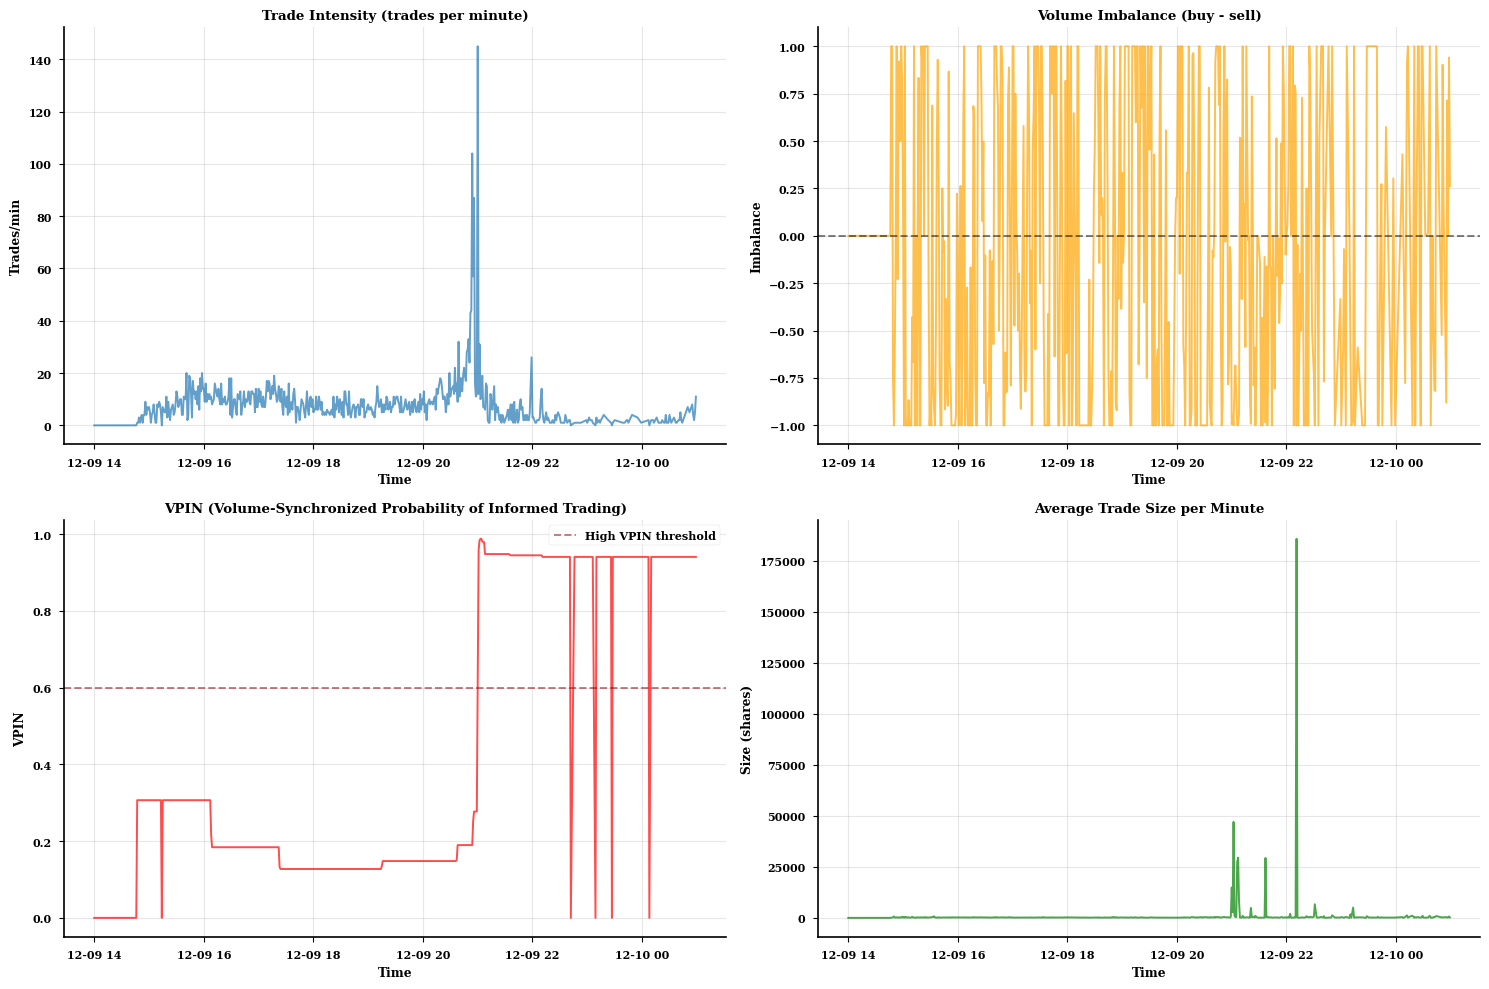


Saved: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/AAPL_trade_features.png


In [15]:
# %% Visualization 1: Trade features dashboard
print("\n" + "=" * 60)
print("TRADE FEATURES VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Trade intensity
axes[0, 0].plot(features_df.index, features_df["trade_trade_intensity"], alpha=0.7)
axes[0, 0].set_title("Trade Intensity (trades per minute)")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Trades/min")
axes[0, 0].grid(True, alpha=0.3)

# Volume imbalance
axes[0, 1].plot(
    features_df.index, features_df["trade_volume_imbalance"], alpha=0.7, color="orange"
)
axes[0, 1].axhline(0, color="black", linestyle="--", alpha=0.5)
axes[0, 1].set_title("Volume Imbalance (buy - sell)")
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Imbalance")
axes[0, 1].grid(True, alpha=0.3)

# VPIN
axes[1, 0].plot(features_df.index, features_df["trade_vpin"], alpha=0.7, color="red")
axes[1, 0].axhline(
    0.6, color="darkred", linestyle="--", alpha=0.5, label="High VPIN threshold"
)
axes[1, 0].set_title("VPIN (Volume-Synchronized Probability of Informed Trading)")
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("VPIN")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Average trade size
axes[1, 1].plot(
    features_df.index, features_df["trade_avg_trade_size"], alpha=0.7, color="green"
)
axes[1, 1].set_title("Average Trade Size per Minute")
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Size (shares)")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f"{TICKER}_trade_features.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\nSaved: {FIGURES_DIR / f'{TICKER}_trade_features.png'}")


AGGREGATE FEATURES VISUALIZATION


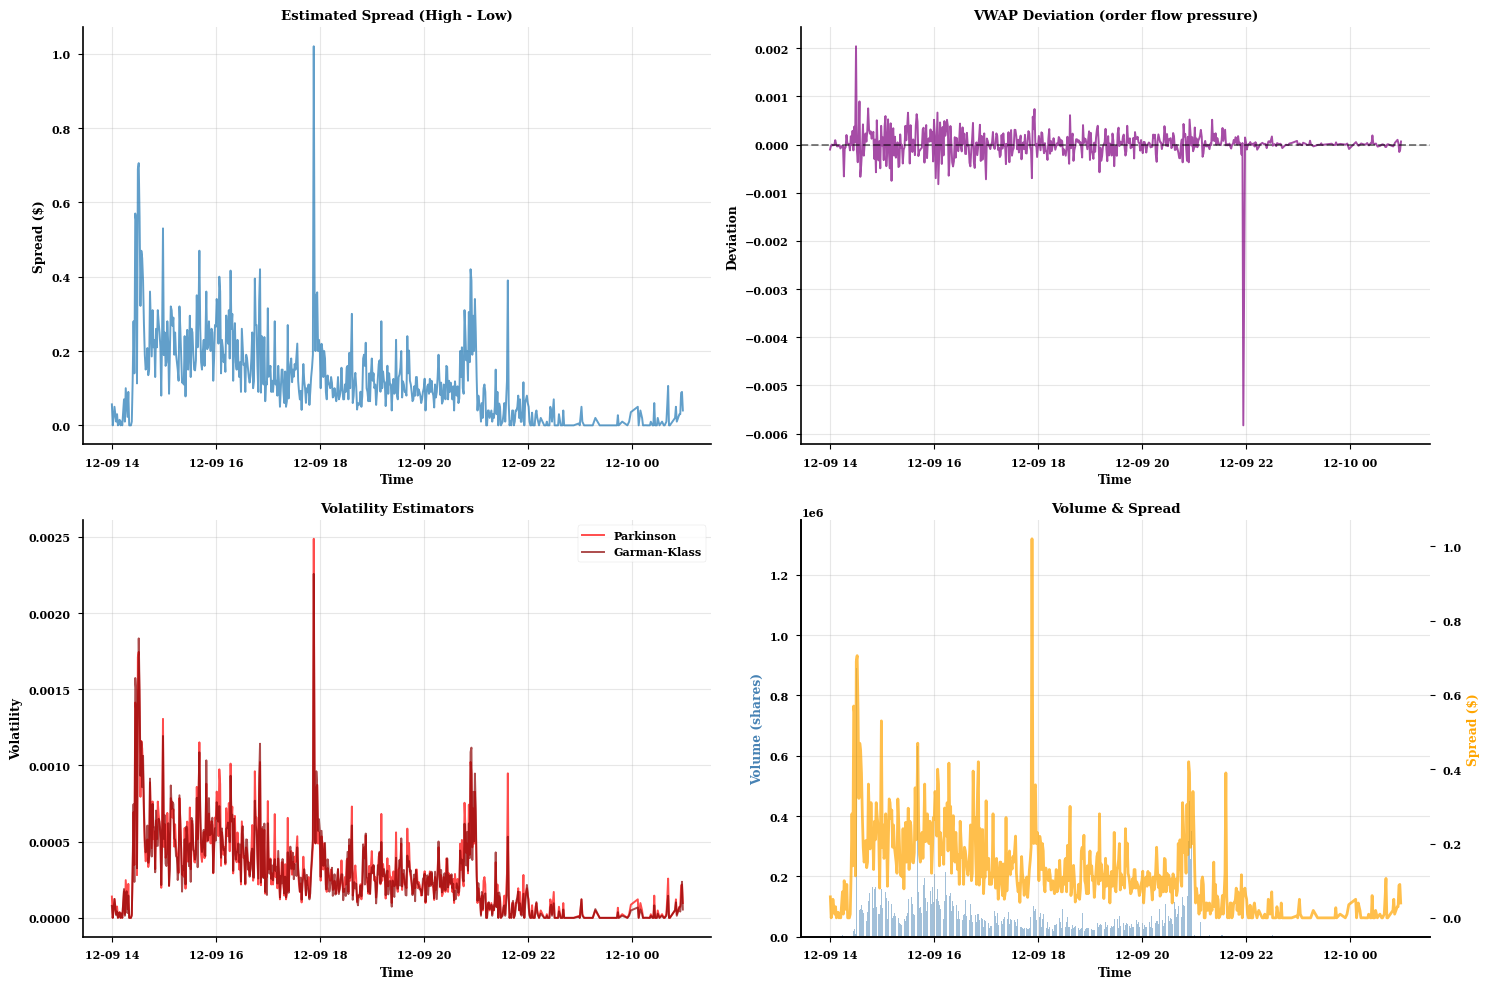


Saved: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/AAPL_aggregate_features.png


In [16]:
# %% Visualization 2: Aggregate features dashboard
print("\n" + "=" * 60)
print("AGGREGATE FEATURES VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Spread
axes[0, 0].plot(features_df.index, features_df["agg_estimated_spread"], alpha=0.7)
axes[0, 0].set_title("Estimated Spread (High - Low)")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Spread ($)")
axes[0, 0].grid(True, alpha=0.3)

# VWAP deviation
axes[0, 1].plot(
    features_df.index, features_df["agg_vwap_deviation"], alpha=0.7, color="purple"
)
axes[0, 1].axhline(0, color="black", linestyle="--", alpha=0.5)
axes[0, 1].set_title("VWAP Deviation (order flow pressure)")
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Deviation")
axes[0, 1].grid(True, alpha=0.3)

# Volatility
axes[1, 0].plot(
    features_df.index,
    features_df["agg_parkinson_vol"],
    alpha=0.7,
    label="Parkinson",
    color="red",
)
axes[1, 0].plot(
    features_df.index,
    features_df["agg_gk_vol"],
    alpha=0.7,
    label="Garman-Klass",
    color="darkred",
)
axes[1, 0].set_title("Volatility Estimators")
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Volatility")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Volume with spread overlay
ax2 = axes[1, 1].twinx()
axes[1, 1].bar(
    features_df.index,
    features_df["agg_volume"],
    alpha=0.5,
    width=0.0005,
    color="steelblue",
)
ax2.plot(
    features_df.index,
    features_df["agg_estimated_spread"],
    alpha=0.7,
    color="orange",
    linewidth=2,
)
axes[1, 1].set_title("Volume & Spread")
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Volume (shares)", color="steelblue")
ax2.set_ylabel("Spread ($)", color="orange")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / f"{TICKER}_aggregate_features.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\nSaved: {FIGURES_DIR / f'{TICKER}_aggregate_features.png'}")


FEATURE CORRELATION HEATMAP


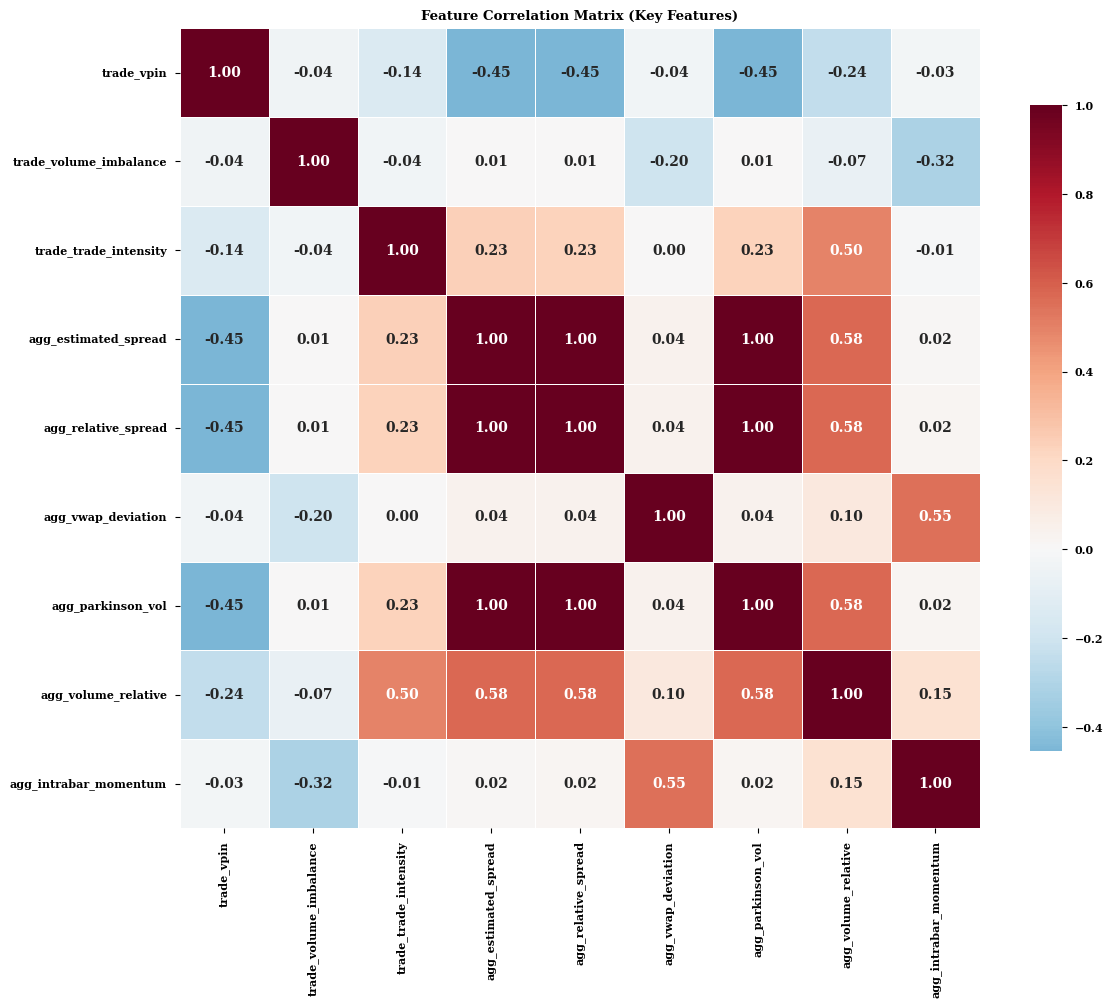


Saved: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/AAPL_feature_correlation.png


In [17]:
# %% Visualization 3: Correlation heatmap (subset of features)
print("\n" + "=" * 60)
print("FEATURE CORRELATION HEATMAP")
print("=" * 60)

# Select key features for visualization
key_features = [
    "trade_vpin",
    "trade_volume_imbalance",
    "trade_trade_intensity",
    "agg_estimated_spread",
    "agg_relative_spread",
    "agg_vwap_deviation",
    "agg_parkinson_vol",
    "agg_volume_relative",
    "agg_intrabar_momentum",
]

# Filter to available features
available_key_features = [f for f in key_features if f in features_df.columns]

# Compute correlation
corr_subset = features_df[available_key_features].corr()

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(
    corr_subset,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax,
)
ax.set_title("Feature Correlation Matrix (Key Features)")
plt.tight_layout()
plt.savefig(
    FIGURES_DIR / f"{TICKER}_feature_correlation.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\nSaved: {FIGURES_DIR / f'{TICKER}_feature_correlation.png'}")

## Save Features for Next Notebook


In [18]:
# %% Save features to processed data directory
print("\n" + "=" * 60)
print("SAVING FEATURES")
print("=" * 60)

# Ensure processed directory exists
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Save main features DataFrame
output_file = PROCESSED_DATA_DIR / f"{TICKER}_features_phase1.parquet"
features_df.to_parquet(output_file)
print(f"\n✓ Saved features to: {output_file}")
print(f"  Shape: {features_df.shape}")
print(f"  File size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")

# Save metadata
metadata = {
    "created_at": datetime.now().isoformat(),
    "ticker": TICKER,
    "date": DATE,
    "data_source": "polygon.io",
    "phase": 1,
    "features": {
        "total_count": features_df.shape[1],
        "aggregate_derived": len(agg_feat_cols),
        "trade_derived": len(trade_feat_cols),
        "time_based": len(time_feat_cols),
    },
    "data_shape": list(features_df.shape),
    "time_coverage": {
        "start": str(features_df.index.min()),
        "end": str(features_df.index.max()),
        "duration_hours": (
            features_df.index.max() - features_df.index.min()
        ).total_seconds()
        / 3600,
    },
    "feature_list": features_df.columns.tolist(),
    "notes": [
        "Lee-Ready classification uses aggregate mid-price approximation",
        "NBBO quote features pending (Phase 2)",
        "First 30 minutes dropped for complete rolling features",
    ],
}

metadata_file = PROCESSED_DATA_DIR / f"{TICKER}_features_phase1_metadata.json"
with open(metadata_file, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\n✓ Saved metadata to: {metadata_file}")
print(f"\nMetadata summary:")
print(json.dumps(metadata, indent=2))


SAVING FEATURES

✓ Saved features to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/AAPL_features_phase1.parquet
  Shape: (575, 46)
  File size: 0.17 MB

✓ Saved metadata to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/AAPL_features_phase1_metadata.json

Metadata summary:
{
  "created_at": "2025-12-16T18:31:38.682516",
  "ticker": "AAPL",
  "date": "2024-12-09",
  "data_source": "polygon.io",
  "phase": 1,
  "features": {
    "total_count": 46,
    "aggregate_derived": 27,
    "trade_derived": 15,
    "time_based": 4
  },
  "data_shape": [
    575,
    46
  ],
  "time_coverage": {
    "start": "2024-12-09 14:00:00+00:00",
    "end": "2024-12-10 00:59:00+00:00",
    "duration_hours": 10.983333333333333
  },
  "feature_list": [
    "agg_volume",
    "agg_vwap",
    "agg_open",
    "agg_close",
    "agg_high",
    "agg_low",
    "agg_trades",
    "agg_estimated_spread",
    "agg_mid_price",
    "agg_relative_sp

## Summary & Next Steps


In [19]:
# %% Summary
print("\n" + "=" * 60)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 60)

print(f"\n✓ Phase 1 Features Computed:")
print(f"  Total features: {features_df.shape[1]}")
print(f"  Aggregate-derived: {len(agg_feat_cols)}")
print(f"  Trade-derived: {len(trade_feat_cols)}")
print(f"  Time-based: {len(time_feat_cols)}")

print(f"\n✓ Data Coverage:")
print(f"  Timestamp range: {features_df.index.min()} to {features_df.index.max()}")
print(
    f"  Duration: {(features_df.index.max() - features_df.index.min()).total_seconds() / 3600:.1f} hours"
)
print(f"  Number of 1-minute bars: {len(features_df):,}")

print(f"\n✓ Key Insights:")
print(f"  Average VPIN: {features_df['trade_vpin'].mean():.3f}")
print(f"  Average spread: ${features_df['agg_estimated_spread'].mean():.4f}")
print(
    f"  Average volatility (Parkinson): {features_df['agg_parkinson_vol'].mean():.4f}"
)
print(f"  Buy/Sell imbalance: {features_df['trade_volume_imbalance'].mean():.3f}")

print(f"\n→ Next Notebook: 25_dimensionality_reduction.ipynb")
print(f"   - Apply PCA to reduce {features_df.shape[1]} features → 8-12 components")
print(f"   - Retain 85-90% of variance")
print(f"   - Prepare for regime detection")


FEATURE ENGINEERING COMPLETE

✓ Phase 1 Features Computed:
  Total features: 46
  Aggregate-derived: 27
  Trade-derived: 15
  Time-based: 4

✓ Data Coverage:
  Timestamp range: 2024-12-09 14:00:00+00:00 to 2024-12-10 00:59:00+00:00
  Duration: 11.0 hours
  Number of 1-minute bars: 575

✓ Key Insights:
  Average VPIN: 0.372
  Average spread: $0.1264
  Average volatility (Parkinson): 0.0003
  Buy/Sell imbalance: -0.087

→ Next Notebook: 25_dimensionality_reduction.ipynb
   - Apply PCA to reduce 46 features → 8-12 components
   - Retain 85-90% of variance
   - Prepare for regime detection
